In [10]:
import numpy as np
from astroquery.jplhorizons import Horizons
import astropy.units as u
from astropy.constants import c
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

In [60]:
def get_astroquery_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are "geometric","astrometric" and 
    "apparent"
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        """
        
        obj = Horizons(id = name, location = loc, epochs = t, id_type = 'majorbody')
        obj = obj.vectors(aberrations = cor)
        xyz = np.array([float(obj['x']),float(obj['y']),float(obj['z'])])
        uvw = np.array([float(obj['vx']),float(obj['vy']),float(obj['vz'])])
        return xyz,uvw
    return get_target_xyz    

In [61]:
def LT(t, obsxyz, func):
    """
    Calculates the light time correction to the position vector of an object
    
    Arguments:
    
    t: days
    
    Julian date of observation
    
    obsxyz: np.array
    
    Position vector of observer with respect to the Solar System barycenter.
    
    func: function
    
    A get_target_xyz like function that returns the position and velocity vector of a body at a certain time
    
    Returns:
    
    txyz: np.array
    
    A corrected position vector of the observed object
    
    """
    
    txyz = func(t)
    dist = np.linalg.norm(txyz[0]-obsxyz)
    ltime = float(((dist*u.AU).to(u.m)/c)/u.s)*1/(24*3600)
    d = 10
    while(abs(d)>1e-16):
        txyz = func(t-ltime)
        dist = np.linalg.norm(txyz[0]-obsxyz)
        ltime2 = float(((dist*u.AU).to(u.m)/c)/u.s)*1/(24*3600)
        d = (ltime2-ltime)/ltime
        ltime = ltime2
    return txyz

Running some tests to ascertain that the light time correction function runs appropriately. The angle of correction from our function is compared with the angle produced by astroquery. The step is every 10 days for 400 points

In [48]:
mtheta = []
atheta = []
for i in range(0,400):    
    ts = 2458135.712589224 + 10*i
    get_earth = get_astroquery_function('3',"geometric","g@0")
    get_jup = get_astroquery_function('5',"geometric","g@0")
    exyz = get_earth(ts)
    jxyz = get_jup(ts)
    fxyz = LT(ts, exyz[0], get_jup)
    mtheta.append(206265*(np.linalg.norm(fxyz[0]-jxyz[0])/np.linalg.norm(jxyz[0]-exyz[0])))
    get_cor_jup = get_astroquery_function('5',"astrometric","g@3")
    get_wrong_jup = get_astroquery_function('5',"geometric","g@3")
    axyz = get_cor_jup(ts)
    wxyz = get_wrong_jup(ts)
    atheta.append(206265*(np.linalg.norm(axyz[0]-wxyz[0])/np.linalg.norm(wxyz[0])))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

A graph of the angle of light time correction in arcseconds for a span of 4000 days. The two graphs are almost exactly superimposed.

Text(0,0.5,'θ in Arcseconds')

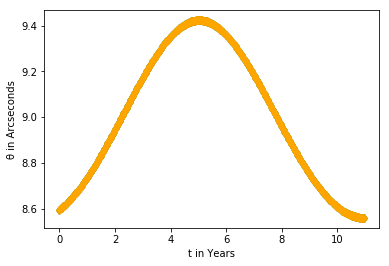

In [65]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,atheta,"d",color = "green")
plt.plot(x*10/365.25,mtheta,"d",color = "orange")
plt.xlabel("t in Years")
plt.ylabel("θ in Arcseconds")

Error in arcseconds. 

Text(0,0.5,'θ in Arcseconds')

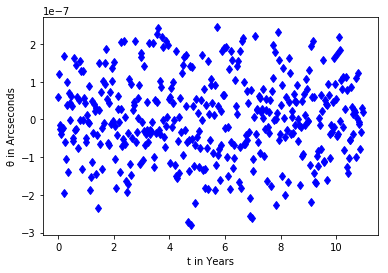

In [66]:
x = np.linspace(0,400,400)
error = []
for i in range(0,len(mtheta)):
    error.append((mtheta[i]-atheta[i]))
plt.plot(x*10/365.25,error,"d",color = "blue")
plt.xlabel("t in Years")
plt.ylabel("θ in Arcseconds")
#Error is random and no higher than 1e-8 order

In [41]:
def SB(earthxyz,vxyz,ts,get_jup):
    """
    Calculates the stellar aberration correction to the position vector of an object

    Arguments:
    
    earthxyz: np.array
    
    The position vector of the observer
    
    vxyz: np.array
    
    The velocity vector of the observer
    
    ts: days
    
    Julian date of observation
    
    get_jup:
    
    A get_target_xyz like function that returns the position and velocity vector of a body at a certain time

    Returns:
    
    v: np.array
    
    A corrected position vector of the observed object
    """
    myjupxyz = LT(ts, earthxyz, get_jup)
    xyz = earthxyz-myjupxyz[0]
    norm_vec = xyz/np.linalg.norm(xyz)
    cvec = float((c.to(u.AU/u.d))/(u.AU/u.d))*norm_vec
    vcorr = cvec - vxyz
    v = (vcorr/np.linalg.norm(vcorr))*np.linalg.norm(xyz)
    return v

In [49]:
mapttheta = []
aapttheta = []
for i in range(0,400):
    ts = 2458135.712589224 +10*i
    get_earth = get_astroquery_function('3',"geometric","g@0")
    get_jup = get_astroquery_function('5',"geometric","g@0")
    exyz = get_earth(ts)
    jxyz = get_jup(ts)
    newjupxyz = SB(exyz[0],exyz[1],ts,get_jup)
    get_cor_jup = get_astroquery_function('5',"apparent","g@3")
    axyz = get_cor_jup(ts)
    jxyz = -(jxyz[0]-exyz[0])
    k = np.linalg.norm(newjupxyz-jxyz)/np.linalg.norm(newjupxyz)
    mapttheta.append(206265*k)
    k = np.linalg.norm(-axyz[0]-jxyz)/np.linalg.norm(axyz[0])
    aapttheta.append(206265*k)


A graph of the angle of stellar aberration correction in arcseconds for a span of 4000 days. The two graphs are again almost exactly superimposed.

Text(0,0.5,'θ in Arcseconds')

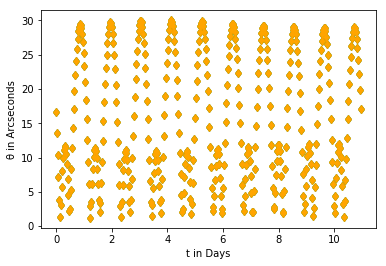

In [64]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,mapttheta,"d",color = "green")
plt.plot(x*10/365.25,aapttheta,"d",color = "orange")
plt.xlabel("t in Years")
plt.ylabel("θ in Arcseconds")

Error in arcseconds. 

Text(0,0.5,'θ in Arcseconds')

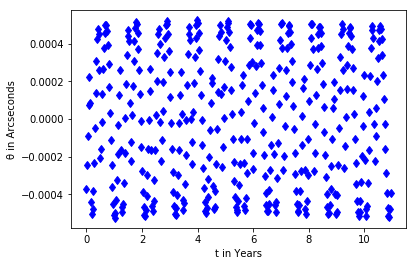

In [68]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,(np.array(mapttheta)-np.array(aapttheta)),"d",color = "blue")
plt.xlabel("t in Years")
plt.ylabel("θ in Arcseconds")